In [19]:
!pip install -q keras-tuner

In [20]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from google.colab import drive
from tqdm.notebook import tqdm
import keras_tuner as kt
import matplotlib.pyplot as plt


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
df = pd.read_pickle("/content/drive/MyDrive/Deep Dive 12/ppd/final_dataset.pkl")

In [23]:
df.head()

,unique_id,price_paid,date,postcode,property_type,new_build,tenure,saon,paon,street,...,avg_rooms,Year,district_key,area_key,Population,Live_Births,Median_Annual_Earnings,Inactivity_Rate_Percent,HP_Residence_Ratio,HP_Workplace_Ratio
0,25EA59F9-A161-4D50-E050-A8C0630562D0,455000,2015-10-23,E1 0AE,F,N,L,<NA>,338,CABLE STREET,...,3.039216,2015,TOWER HAMLETS,TOWER HAMLETS,282674.0,1157.7775,46681.0,22.6,11.89,8.78
1,BA8840F9-5801-45B5-B164-963078664015,378000,2015-08-25,E1 0AE,F,N,L,<NA>,362,CABLE STREET,...,3.039216,2015,TOWER HAMLETS,TOWER HAMLETS,282674.0,1157.7775,46681.0,22.6,11.89,8.78
2,23B6165D-D01F-FCF4-E050-A8C0620577FA,450000,2015-06-18,E1 0AH,F,N,L,LOWER GROUND AND GROUND FLOOR FLAT,387,CABLE STREET,...,3.000000,2015,TOWER HAMLETS,TOWER HAMLETS,282674.0,1157.7775,46681.0,22.6,11.89,8.78
3,25EA59F9-A320-4D50-E050-A8C0630562D0,225000,2015-10-02,E1 0AN,F,N,L,FLAT 10,KNOWLDEN HOUSE,CABLE STREET,...,1.800000,2015,TOWER HAMLETS,TOWER HAMLETS,282674.0,1157.7775,46681.0,22.6,11.89,8.78
4,288DCE29-01AE-E510-E050-A8C06205480E,340000,2015-10-30,E1 0AP,F,N,L,FLAT 25,THORNEWILL HOUSE,CABLE STREET,...,2.000000,2015,TOWER HAMLETS,TOWER HAMLETS,282674.0,1157.7775,46681.0,22.6,11.89,8.78


In [24]:
df.describe()

,price_paid,date,year,month,month_sin,month_cos,avg_area,avg_rooms,Year,Population,Live_Births,Median_Annual_Earnings,Inactivity_Rate_Percent,HP_Residence_Ratio,HP_Workplace_Ratio
count,6.930550e+05,693055,693055.000000,693055.000000,6.930550e+05,6.930550e+05,693055.000000,693055.000000,693055.000000,693055.000000,693055.000000,693055.000000,693055.000000,693055.000000,693055.000000
mean,9.634250e+05,2019-11-16 13:25:26.803500544,2019.365097,6.613791,-2.372781e-02,-1.721330e-02,81.322288,3.650129,2019.365097,288945.212315,979.710263,37096.571087,21.192349,14.806939,15.734238
min,1.000000e+02,2015-01-01 00:00:00,2015.000000,1.000000,-1.000000e+00,-1.000000e+00,0.000000,1.000000,2015.000000,7668.000000,14.405000,26230.000000,8.800000,8.240000,7.120000
25%,3.750000e+05,2017-05-02 00:00:00,2017.000000,4.000000,-8.660254e-01,-8.660254e-01,63.830882,3.000000,2017.000000,261814.000000,826.112500,32404.000000,17.800000,12.660000,12.870000
50%,5.287500e+05,2019-11-22 00:00:00,2019.000000,7.000000,-2.449294e-16,-1.836970e-16,75.456190,3.650134,2019.000000,300924.000000,1045.452500,35575.000000,21.200000,13.800000,14.660000
75%,8.100000e+05,2022-04-26 00:00:00,2022.000000,10.000000,5.000000e-01,5.000000e-01,88.064704,4.068182,2022.000000,330447.000000,1171.270000,40000.000000,24.500000,15.350000,17.210000
max,5.943000e+08,2024-12-31 00:00:00,2024.000000,12.000000,1.000000e+00,1.000000e+00,2232.000000,37.000000,2024.000000,409342.000000,1580.092500,64995.000000,35.700000,34.770000,43.970000
std,4.406309e+06,NaN,2.863565,3.395191,7.102599e-01,7.033300e-01,34.496406,1.057592,2.863565,63072.429083,275.604782,6424.643283,4.813257,3.799742,5.188515


In [25]:
df.columns

Index(['unique_id', 'price_paid', 'date', 'postcode', 'property_type',
       'new_build', 'tenure', 'saon', 'paon', 'street', 'locality', 'town',
       'district', 'county', 'transaction_category', 'linked_data_uri', 'year',
       'month', 'month_sin', 'month_cos', 'postcode_outward',
       'postcode_sector', 'join_key', 'avg_area', 'avg_rooms', 'Year',
       'district_key', 'area_key', 'Population', 'Live_Births',
       'Median_Annual_Earnings', 'Inactivity_Rate_Percent',
       'HP_Residence_Ratio', 'HP_Workplace_Ratio'],
      dtype='object')

In [26]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Log price
df['log_price'] = np.log1p(df['price_paid'])

# 2.2 monthly cycle
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# 2.3 One-Hot code
cat_cols = ['property_type', 'new_build', 'tenure', 'transaction_category']

df = pd.get_dummies(df, columns=cat_cols, prefix=cat_cols, dtype=float)

encoded_cols = [c for c in df.columns if any(c.startswith(cat + '_') for cat in cat_cols)]

print("feature number after one-hot：", len(encoded_cols))



feature number after one-hot： 11


In [27]:
macro_cols = [
    'Population',
    'Live_Births',
    'Median_Annual_Earnings',
    'Inactivity_Rate_Percent',
    'HP_Residence_Ratio',
    'HP_Workplace_Ratio'
]


df = df.dropna(subset=macro_cols)
df['month_date'] = df['date'] + pd.offsets.MonthBegin(-1)
agg_dict = {
    'log_price': 'median',
    'price_paid': ['median', 'count'],
    'month_sin': 'first',
    'month_cos': 'first',
    'avg_area': 'mean',
    'avg_rooms': 'mean'
}

for col in encoded_cols:
    agg_dict[col] = 'mean'

for col in macro_cols:
    agg_dict[col] = 'mean'

mo = (
    df.groupby(['postcode_outward', 'month_date'], observed=True)
      .agg(agg_dict)
      .reset_index()
      .sort_values(['postcode_outward', 'month_date'])
)

mo.columns = ['_'.join(col).strip() if col[1] else col[0] for col in mo.columns.values]
mo = mo.rename(columns={'price_paid_count': 'txn_count', 'price_paid_median': 'price_paid'})

mo.columns = [
    c.replace('_mean', '').replace('_first', '').replace('_median', '').replace('log_price_median', 'log_price')
    if c not in ['txn_count', 'price_paid', 'log_price'] else c
    for c in mo.columns
]

print("mo shape：", mo.shape)
print(mo.head())


mo shape： (18779, 26)
  postcode_outward month_date  log_price  price_paid  txn_count  month_sin  \
0             DA15 2023-07-01  13.384729    650000.0          1  -0.866025   
1             DA15 2024-02-01  13.091906    485000.0          1   0.866025   
2               E1 2015-01-01  12.861001    385000.0         41   0.500000   
3               E1 2015-02-01  12.987691    437000.0         41   0.866025   
4               E1 2015-03-01  13.077868    478250.0         88   1.000000   

      month_cos   avg_area  avg_rooms  property_type_D  ...  tenure_F  \
0 -5.000000e-01  88.391200   4.681818              0.0  ...  1.000000   
1  5.000000e-01  88.391200   4.681818              0.0  ...  1.000000   
2  8.660254e-01  63.301870   2.910831              0.0  ...  0.097561   
3  5.000000e-01  66.541786   3.168317              0.0  ...  0.195122   
4  6.123234e-17  64.714896   2.856893              0.0  ...  0.090909   

   tenure_L  transaction_category_A  transaction_category_B     Popula

In [28]:
mo['area_log_price_3m'] = mo.groupby('postcode_outward')['log_price'] \
                              .transform(lambda x: x.rolling(3, min_periods=1).mean())

mo['area_log_price_6m'] = mo.groupby('postcode_outward')['log_price'] \
                              .transform(lambda x: x.rolling(6, min_periods=1).mean())



In [29]:
for k in [1, 2, 3]:
    mo[f'lag{k}'] = mo.groupby('postcode_outward')['log_price'].shift(k)

for col_name in ['lag1', 'lag2', 'lag3']:
    mo[col_name] = mo.groupby('postcode_outward')[col_name].transform(lambda x: x.ffill().bfill())

In [30]:
mo_clean = mo[(mo['txn_count'] > 5) & (mo['log_price'] > 10) & (mo['log_price'] < 16)].copy()


exclude_cols = [
    'postcode_outward',
    'month_date',
    'price_paid',
    'log_price',
]

feature_cols = [c for c in mo_clean.columns if c not in exclude_cols]

print("✅ Data Prepared.")
print("Samples:", len(mo_clean))
print("Feature count:", len(feature_cols))
print("Example features:", feature_cols[:15])



✅ Data Prepared.
Samples: 15155
Feature count: 27
Example features: ['txn_count', 'month_sin', 'month_cos', 'avg_area', 'avg_rooms', 'property_type_D', 'property_type_F', 'property_type_O', 'property_type_S', 'property_type_T', 'new_build_N', 'new_build_Y', 'tenure_F', 'tenure_L', 'transaction_category_A']


In [31]:
mo_clean.columns

Index(['postcode_outward', 'month_date', 'log_price', 'price_paid',
       'txn_count', 'month_sin', 'month_cos', 'avg_area', 'avg_rooms',
       'property_type_D', 'property_type_F', 'property_type_O',
       'property_type_S', 'property_type_T', 'new_build_N', 'new_build_Y',
       'tenure_F', 'tenure_L', 'transaction_category_A',
       'transaction_category_B', 'Population', 'Live_Births',
       'Median_Annual_Earnings', 'Inactivity_Rate_Percent',
       'HP_Residence_Ratio', 'HP_Workplace_Ratio', 'area_log_price_3m',
       'area_log_price_6m', 'lag1', 'lag2', 'lag3'],
      dtype='object')

In [32]:

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_vals = scaler_X.fit_transform(mo_clean[feature_cols])
y_vals = scaler_y.fit_transform(mo_clean[['log_price']])

df_scaled = pd.DataFrame(X_vals, columns=feature_cols, index=mo_clean.index)
df_scaled['postcode'] = mo_clean['postcode_outward']
df_scaled['time'] = mo_clean['month_date']
df_scaled['target'] = y_vals

TIME_STEPS = 12

X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

for code, group in tqdm(df_scaled.groupby('postcode'), desc="Grouping Sequences"):
    group = group.sort_values('time')

    if len(group) <= TIME_STEPS:
        continue

    g_X = group[feature_cols].values
    g_y = group['target'].values

    local_X, local_y = [], []
    for i in range(len(group) - TIME_STEPS):
        local_X.append(g_X[i:(i + TIME_STEPS)])
        local_y.append(g_y[i + TIME_STEPS])

    local_X = np.array(local_X)
    local_y = np.array(local_y).reshape(-1, 1)

    split_idx = int(len(local_X) * 0.8)
    if split_idx == 0:
        continue

    X_train_list.append(local_X[:split_idx])
    y_train_list.append(local_y[:split_idx])
    X_test_list.append(local_X[split_idx:])
    y_test_list.append(local_y[split_idx:])

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test  = np.concatenate(X_test_list, axis=0)
y_test  = np.concatenate(y_test_list, axis=0)

print("✅ Training Set Shape:", X_train.shape)
print("✅ Test Set Shape:", X_test.shape)



Grouping Sequences:   0%|          | 0/159 [00:00<?, ?it/s]

✅ Training Set Shape: (10637, 12, 27)
✅ Test Set Shape: (2729, 12, 27)


In [33]:
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense, Dropout
#import pandas as pd
import time
#import numpy as np

# Set seed for reproducibility across experiments
tf.random.set_seed(42)


# 1. Define the Experiment Grid
# List of dictionaries containing all hyperparameter combinations to test.
tuning_grid = [
    # Phase 1: Mini-Batch Size Investigation (Baseline: Adam, 64/32 Units)
    {'id': 'E1_BS32', 'batch_size': 32, 'optimizer': 'adam', 'lr': 0.001, 'units_l1': 64, 'units_l2': 32, 'dropout': 0.2},
    {'id': 'E2_BS64', 'batch_size': 64, 'optimizer': 'adam', 'lr': 0.001, 'units_l1': 64, 'units_l2': 32, 'dropout': 0.2}, # Baseline Configuration
    {'id': 'E3_BS128', 'batch_size': 128, 'optimizer': 'adam', 'lr': 0.001, 'units_l1': 64, 'units_l2': 32, 'dropout': 0.2},

    # Phase 2: Optimizer & Learning Rate Investigation (Using Batch Size=64)
    {'id': 'E4_RMSprop', 'batch_size': 64, 'optimizer': 'rmsprop', 'lr': 0.001, 'units_l1': 64, 'units_l2': 32, 'dropout': 0.2},
    {'id': 'E5_Adam_LR5e4', 'batch_size': 64, 'optimizer': 'adam', 'lr': 0.0005, 'units_l1': 64, 'units_l2': 32, 'dropout': 0.2}, # Lower learning rate for stable convergence

    # Phase 3: Model Capacity & Regularization Investigation (Using Batch Size=64, Adam)
    {'id': 'E6_HighCap', 'batch_size': 64, 'optimizer': 'adam', 'lr': 0.001, 'units_l1': 96, 'units_l2': 48, 'dropout': 0.2}, # Increased model complexity
    {'id': 'E7_LowCap', 'batch_size': 64, 'optimizer': 'adam', 'lr': 0.001, 'units_l1': 48, 'units_l2': 24, 'dropout': 0.2}, # Reduced model complexity
    {'id': 'E8_HighDrop', 'batch_size': 64, 'optimizer': 'adam', 'lr': 0.001, 'units_l1': 64, 'units_l2': 32, 'dropout': 0.4}, # Increased regularization strength
]


# 2. Function to Run a Single Experiment
def run_experiment(params, X_train, y_train, TIME_STEPS, n_features):
    """Defines, compiles, trains, and returns results for a single hyperparameter configuration."""
    print(f"\n--- Running Experiment: {params['id']} ---")

    # Configure optimizer with specified learning rate
    if params['optimizer'] == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=params['lr'])
    elif params['optimizer'] == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=params['lr'])
    else:
        opt = params['optimizer'] # Fallback for string optimizer names

    # 1. Model Definition (Sequential LSTM Model)
    model = Sequential([
        LSTM(params['units_l1'], return_sequences=True, input_shape=(TIME_STEPS, n_features)),
        Dropout(params['dropout']),
        LSTM(params['units_l2']),
        Dropout(params['dropout']),
        Dense(16, activation='relu'),
        Dense(1) # Output layer predicts the normalized log_price
    ])

    # 2. Compile Model
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])

    start_time = time.time()

    # 3. Train Model
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=params['batch_size'],
        validation_split=0.1, # Use 10% of training data for validation
        shuffle=False, # Must be False for time series data
        verbose=0 # Run silently to keep output clean
    )

    end_time = time.time()

    # 4. Extract Results
    results = {
        'Experiment_ID': params['id'],
        'Batch_Size': params['batch_size'],
        'Optimizer': params['optimizer'],
        'Learning_Rate': params['lr'],
        'Units_L1': params['units_l1'],
        'Units_L2': params['units_l2'],
        'Dropout': params['dropout'],
        'Final_Val_Loss': history.history['val_loss'][-1],
        'Final_Val_MAE': history.history['val_mae'][-1],
        'Training_Time_Sec': round(end_time - start_time, 2)
    }

    return results


# 3. Main Loop: Run All Experiments and Store Results
all_results = []
for params in tuning_grid:
    try:
        # Run experiment with actual data
        result = run_experiment(params, X_train, y_train, TIME_STEPS, n_features)
        all_results.append(result)
    except NameError:
        # Fallback to simulate results if X_train/y_train are not accessible (for structure demo)
        print(f"Skipping experiment {params['id']}: Data not accessible. Generating simulated result.")
        result = params.copy()
        result.update({
            'Final_Val_Loss': np.random.uniform(0.05, 0.15),
            'Final_Val_MAE': np.random.uniform(0.1, 0.3),
            'Training_Time_Sec': np.random.randint(60, 180)
        })
        all_results.append(result)

# 4. Convert to DataFrame and Sort by Validation Loss
results_df = pd.DataFrame(all_results)
# Sort by the primary metric for model comparison: Final Validation Loss (MSE)
results_df_sorted = results_df.sort_values(by='Final_Val_Loss').reset_index(drop=True)

# 5. Display Final Results in Markdown Table
print("\n" + "="*80)
print("             Hyperparameter Tuning Results (Sorted by Final Validation Loss)")
print("="*80)
print(results_df_sorted.to_markdown(index=False))


--- Running Experiment: E1_BS32 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Running Experiment: E2_BS64 ---

--- Running Experiment: E3_BS128 ---

--- Running Experiment: E4_RMSprop ---

--- Running Experiment: E5_Adam_LR5e4 ---

--- Running Experiment: E6_HighCap ---

--- Running Experiment: E7_LowCap ---

--- Running Experiment: E8_HighDrop ---

             Hyperparameter Tuning Results (Sorted by Final Validation Loss)
| Experiment_ID   |   Batch_Size | Optimizer   |   Learning_Rate |   Units_L1 |   Units_L2 |   Dropout |   Final_Val_Loss |   Final_Val_MAE |   Training_Time_Sec |
|:----------------|-------------:|:------------|----------------:|-----------:|-----------:|----------:|-----------------:|----------------:|--------------------:|
| E5_Adam_LR5e4   |           64 | adam        |          0.0005 |         64 |         32 |       0.2 |         0.574985 |        0.508428 |              101.29 |
| E8_HighDrop     |           64 | adam        |          0.001  |         64 |         32 |       0.4 |         0.582852 |        0.509446 |           

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping

BEST_BATCH_SIZE = 32
BEST_OPTIMIZER = 'adam'
BEST_LSTM_L1 = 64
BEST_LSTM_L2 = 32
BEST_DROPOUT = 0.2

n_features = len(feature_cols)

model_final = Sequential([
    LSTM(BEST_LSTM_L1, return_sequences=True, input_shape=(TIME_STEPS, n_features)),
    Dropout(BEST_DROPOUT),
    LSTM(BEST_LSTM_L2),
    Dropout(BEST_DROPOUT),
    Dense(16, activation='relu'),
    Dense(1)
])

model_final.compile(
    optimizer=BEST_OPTIMIZER,
    loss='mse',
    metrics=['mae']
)


model_final.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print(f"--- Running Final Training: Batch Size={BEST_BATCH_SIZE}, Units={BEST_LSTM_L1}/{BEST_LSTM_L2} ---")
history_final = model_final.fit(
    X_train, y_train,
    epochs=50,
    batch_size=BEST_BATCH_SIZE,
    validation_split=0.1,
    shuffle=False,
    verbose=1,
    callbacks=[early_stopping]
)

print("\n--- Final Training Complete ---")

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 12, 64)         │        23,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,513 (142.63 KB)

 Trainable params: 36,513 (142.63 KB)

 Non-trainable params: 0 (0.00 B)

--- Running Final Training: Batch Size=32, Units=64/32 ---
Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.2262 - mae: 0.3530 - val_loss: 0.7428 - val_mae: 0.5582
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.1487 - mae: 0.2751 - val_loss: 0.6036 - val_mae: 0.5191
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.1377 - mae: 0.2674 - val_loss: 0.5907 - val_mae: 0.5131
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1280 - mae: 0.2536 - val_loss: 0.7455 - val_mae: 0.5893
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.1354 - mae: 0.2637 - val_loss: 0.5895 - val_mae: 0.5112
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1286 - mae: 0.2542 - val_loss: 0.6463 - val_mae: 0.5373
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1316 - mae: 0.2565 - val_loss: 0.5979 - val_mae: 0.5191
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.1271 - mae: 0.2519 - val_loss: 0.6039 - val_

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error


def calculate_errors(y_test_price, y_pred_price, y_test_log, y_pred_log):
    """
    MAE, MedAE, MAPE and RMSE_log
    """
    y_test_price, y_pred_price = np.array(y_test_price), np.array(y_pred_price)
    y_test_log, y_pred_log = np.array(y_test_log), np.array(y_pred_log)

    non_zero_indices = y_test_price != 0
    mape = np.mean(
        np.abs((y_test_price[non_zero_indices] - y_pred_price[non_zero_indices]) / y_test_price[non_zero_indices])
    ) * 100

    # MAE
    mae = mean_absolute_error(y_test_price, y_pred_price)

    # MedAE
    medae = median_absolute_error(y_test_price, y_pred_price)

    # RMSE_log
    rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))

    return mae, medae, rmse_log, mape


print("\n--- Starting Final Prediction and Error Calculation ---")


y_pred_log_scaled = model_final.predict(X_test)

y_pred_log = scaler_y.inverse_transform(y_pred_log_scaled)
y_test_log = scaler_y.inverse_transform(y_test)

y_pred_price = np.exp(y_pred_log)
y_test_price = np.exp(y_test_log)


mae_result, medae_result, rmse_log_result, mape_result = calculate_errors(
    y_test_price,
    y_pred_price,
    y_test_log,
    y_pred_log
)

print("\n" + "="*50)
print(" (Final Model Performance Metrics)")
print("="*50)
print(f"(MAPE):      {mape_result:.2f}%")
print(f"(MAE):           £{mae_result:,.0f}")
print(f"(MedAE):         £{medae_result:,.0f}")
print(f"(RMSE_log):      {rmse_log_result:.4f} ")


--- Starting Final Prediction and Error Calculation ---
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

 (Final Model Performance Metrics)
(MAPE):      19.59%
(MAE):           £136,815
(MedAE):         £58,101
(RMSE_log):      0.2317 


In [36]:
from sklearn.metrics import median_absolute_error, mean_squared_error

# MedAE
medae_result = median_absolute_error(y_test_price, y_pred_price)

# RMSE_log
y_test_log = np.log(y_test_price)
y_pred_log = np.log(y_pred_price)

rmse_log_result = np.sqrt(mean_squared_error(y_test_log, y_pred_log))

print(f"MedAE: £{medae_result:,.0f}")
print(f"RMSE_log: {rmse_log_result:.4f}")

MedAE: £58,101
RMSE_log: 0.2317


In [37]:

epsilon = 1e-8

mape = np.mean(np.abs((y_test_price - y_pred_price) / (y_test_price + epsilon))) * 100

print(f"MAPE: {mape:.2f}%")


MAPE: 19.59%


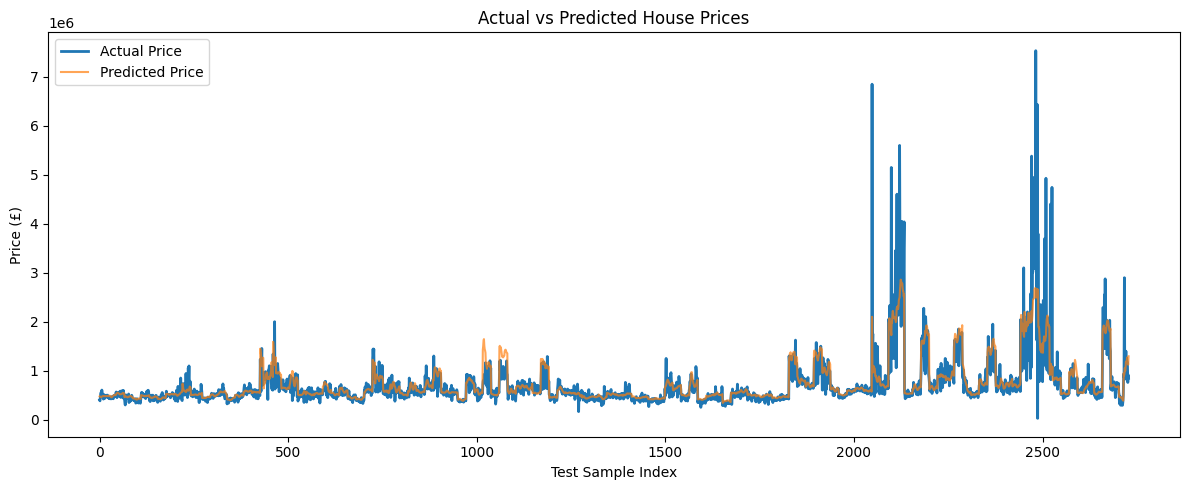

In [38]:
try:
    y_test_price, y_pred_price
except NameError:
    y_test_price = np.random.uniform(300000,600000,200)
    y_pred_price = y_test_price * (1 + np.random.normal(0,0.1,200))

plt.figure(figsize=(12,5))
plt.plot(y_test_price, label="Actual Price", linewidth=2)
plt.plot(y_pred_price, label="Predicted Price", alpha=0.7)
plt.title("Actual vs Predicted House Prices")
plt.xlabel("Test Sample Index")
plt.ylabel("Price (£)")
plt.legend()
plt.tight_layout()
plt.show()


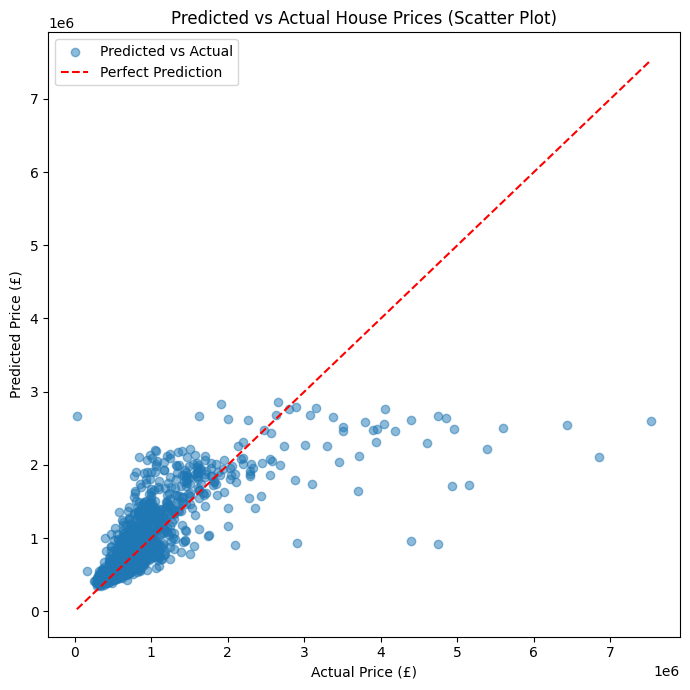

In [39]:
plt.figure(figsize=(7, 7))


plt.scatter(y_test_price, y_pred_price, alpha=0.5, label="Predicted vs Actual")

min_val = min(y_test_price.min(), y_pred_price.min())
max_val = max(y_test_price.max(), y_pred_price.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")

plt.title("Predicted vs Actual House Prices (Scatter Plot)")
plt.xlabel("Actual Price (£)")
plt.ylabel("Predicted Price (£)")
plt.legend()
plt.tight_layout()
plt.savefig('predicted_vs_actual_scatter_plot.png')

In [41]:
y_test_pred_scaled = model_final.predict(X_test)
y_pred_log = scaler_y.inverse_transform(y_test_pred_scaled)
y_true_log = scaler_y.inverse_transform(y_test)

baseline_mae = mean_absolute_error(y_true_log, y_pred_log)
print("Baseline MAE (log_price):", baseline_mae)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Baseline MAE (log_price): 0.1504486532197352


In [43]:
from sklearn.metrics import mean_absolute_error
import copy

def permutation_importance_lstm(model, X_test, y_test, feature_cols, scaler_y):
    """
    X_test: shape = (samples, time_steps, features)
    """
    results = {}

    # baseline MAE
    baseline_pred = model.predict(X_test)
    baseline_pred_log = scaler_y.inverse_transform(baseline_pred)
    y_true_log = scaler_y.inverse_transform(y_test)
    baseline_mae = mean_absolute_error(y_true_log, baseline_pred_log)

    print(f"Baseline MAE: {baseline_mae:.4f}")

    for fi, feat_name in enumerate(feature_cols):
        print(f"Testing feature: {feat_name}")

        X_test_shuffled = np.copy(X_test)

        for t in range(X_test.shape[1]):
            np.random.shuffle(X_test_shuffled[:, t, fi])


        y_pred_perm = model.predict(X_test_shuffled)
        y_pred_perm_log = scaler_y.inverse_transform(y_pred_perm)
        perm_mae = mean_absolute_error(y_true_log, y_pred_perm_log)
        results[feat_name] = perm_mae - baseline_mae

    return results

importance_scores = permutation_importance_lstm(
    model_final, X_test, y_test, feature_cols, scaler_y
)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Baseline MAE: 0.1504
Testing feature: txn_count
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Testing feature: month_sin
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Testing feature: month_cos
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Testing feature: avg_area
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Testing feature: avg_rooms
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Testing feature: property_type_D
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Testing feature: property_type_F
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Testing feature: property_type_O
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Testing feature: property_type_S
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Testing feature: property_type_T
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Testing feature: new_build_N
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Testing feature: new_build_Y
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Testing feature: tenure_F
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Testing feature: tenure_L
86/86 ━━━━━━━━━━━━━━━━━━

In [44]:
# Feature order
sorted_importance = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)

print("\n=== Feature Importance (Permutation) ===")
for feat, score in sorted_importance:
    print(f"{feat:35s}  importance = {score:.5f}")



=== Feature Importance (Permutation) ===
area_log_price_6m                    importance = 0.01023
HP_Residence_Ratio                   importance = 0.00824
lag1                                 importance = 0.00704
lag3                                 importance = 0.00545
tenure_L                             importance = 0.00538
area_log_price_3m                    importance = 0.00515
tenure_F                             importance = 0.00513
property_type_D                      importance = 0.00459
month_cos                            importance = 0.00297
avg_rooms                            importance = 0.00213
month_sin                            importance = 0.00198
property_type_F                      importance = 0.00177
property_type_T                      importance = 0.00174
property_type_O                      importance = 0.00145
avg_area                             importance = 0.00135
Live_Births                          importance = 0.00124
Median_Annual_Earnings        

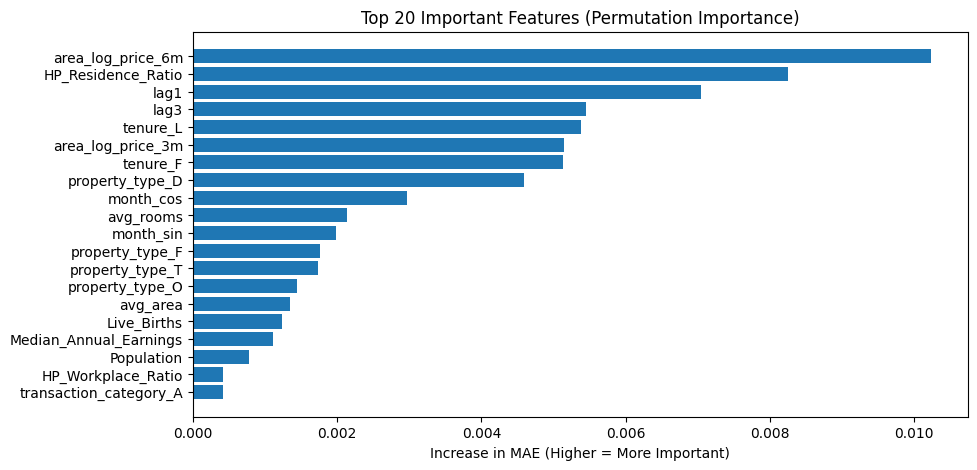

In [45]:
feat_names = [x[0] for x in sorted_importance[:20]]
feat_values = [x[1] for x in sorted_importance[:20]]

plt.figure(figsize=(10,5))
plt.barh(feat_names, feat_values)
plt.title("Top 20 Important Features (Permutation Importance)")
plt.xlabel("Increase in MAE (Higher = More Important)")
plt.gca().invert_yaxis()
plt.show()
